# Dm neurons connectivity analysis

This notebook aims to explore if there are specific subnetworks among specifics Dm neurons in the medulla. The analysis includes only direct connectivity between neurons and could include an upstream input pathway neuron from the lamina.
It employs graph anlysis thecnics to explore connectivity and possible subnetworks.

In [1]:
# Importing packages
import pandas as pd
import os
import numpy as np
import fafbseg
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter

C:\Users\smolina\Anaconda3\envs\EM2\lib\site-packages\blessed\terminal.py:183: UserWarning: Failed to setupterm(kind='xterm-color'): Could not find terminal xterm-color
  warnings.warn(msg)


### 0. Overall initial conditions

In [129]:
syn_threshold = 3 # Minimun number of synapses to consider

### 1. Getting ids for all Dm neuron types

First, we need to get all the cell IDs for all Dm neuron types.
Second, we need to query their connectivity. For that we can: A) either getting all inputs and ouputs and filter out non-Dm neurons, or B) getting directly the direct connectivity among selected neurons. In the following cells, the latter apporach is being explored. 

In [130]:
# Uploading IDs from txt files

dataPath = r'D:\Connectomics-Data\FlyWire\Txts'
root_ids_dm = os.path.join(dataPath, 'root_ids_sub_class_distal_medulla_side_rigth.txt')
root_ids_L = os.path.join(dataPath, 'root_ids_L3_side_rigth.txt')

dm_ids_ls = pd.read_csv(root_ids_dm, sep=",", header=None).values.flatten().tolist()
L_ids_ls = pd.read_csv(root_ids_L, sep=",", header=None).values.flatten().tolist()
cell_ids_ls = dm_ids_ls # dm_ids_ls+L_ids_ls

# Getting the cell identity per each ID
cell_type_ls = fafbseg.flywire.search_annotations(cell_ids_ls).cell_type.tolist()

#  Printing
print(f'Total number of cells in the analysis: {len(cell_ids_ls)}')

Using materialization version 783.
Total number of cells in the analysis: 3239


In [131]:
# Some small fixes in the list of cells 
# Replace 'CB3849' with 'Dm16'
cell_type_ls = [label.replace('CB3849', 'Dm16') if isinstance(label, str) else label for label in cell_type_ls]

In [132]:
# Checing community annotations
counter = Counter(cell_type_ls)
unique_count = len(counter)
print(counter)

Counter({'Dm3': 1261, 'Dm2': 580, 'Dm8': 366, 'Dm10': 245, 'Dm15': 192, 'Dm9': 127, 'Dm12': 107, 'Dm11': 63, 'Dm20': 45, 'Dm16': 42, 'Dm4': 39, 'Dm1': 35, 'Dm6': 28, 'Dm13': 24, 'Dm18': 22, nan: 21, 'Dm14': 14, 'Dm19': 13, 'Dm17': 4, 'Mi4': 3, 'Dm21': 2, 'Mi9': 2, 'Mi15': 2, 'Lawf1': 1, 'L3': 1})


In [133]:
# Function to make unique labels for all copies of a cell type

def make_unique(labels):
    """Make list labels unique by appending a suffix to duplicates."""
    counts = {}
    unique_labels = []
    for label in labels:
        if label in counts:
            counts[label] += 1
            unique_labels.append(f"{label}_{counts[label]}")
        else:
            counts[label] = 0
            unique_labels.append(label)
    return unique_labels

cell_type_ls_unique_labels =  make_unique(cell_type_ls)


In [134]:
# Creating a data set data frame

df = pd.DataFrame({
    'ids': cell_ids_ls,
    'symbol': cell_type_ls,
    'unique_label' : cell_type_ls_unique_labels
})

# Small name fixes
# Replace 'Dm8' with 'Dm16' in the 'symbol' column
df['symbol'] = df['symbol'].replace('CB3849', 'Dm16')
df['unique_label'] = df['unique_label'].replace('CB3849', 'Dm16')

display(df.head())

,ids,symbol,unique_label
0,720575940628299786,Dm19,Dm19
1,720575940632412175,Dm8,Dm8
2,720575940625383442,Dm13,Dm13
3,720575940645773335,Dm9,Dm9
4,720575940626997276,Mi4,Mi4


### 2. Cleaning the data set

Since the current annotations have not been fully curated, here there is some cleaning od the data based on annotations names.

In [135]:
# Filtering the data frame if needed
# Filter rows where 'symbol' starts with 'Dm' or 'L3'
filtered_df = df[df['symbol'].str.startswith('Dm') | df['symbol'].str.startswith('Dm')]

cell_ids = filtered_df.ids.tolist()
cell_types = filtered_df.symbol.tolist()
unique_labels = filtered_df.unique_label.tolist()

# Generate the dictionary with IDs as keys and unique labels as values
cell_id_to_type = {cell_ids[i]: unique_labels[i] for i in range(len(cell_ids)) if not (isinstance(unique_labels[i], float) and math.isnan(unique_labels[i]))}

#Printing
display(filtered_df.head())
print(f'Included cell types: {filtered_df.symbol.unique()}')
print(f'Total number of cells: {len(cell_ids)}')


,ids,symbol,unique_label
0,720575940628299786,Dm19,Dm19
1,720575940632412175,Dm8,Dm8
2,720575940625383442,Dm13,Dm13
3,720575940645773335,Dm9,Dm9
5,720575940618698781,Dm20,Dm20


Included cell types: ['Dm19' 'Dm8' 'Dm13' 'Dm9' 'Dm20' 'Dm6' 'Dm1' 'Dm2' 'Dm3' 'Dm16' 'Dm15'
 'Dm14' 'Dm10' 'Dm21' 'Dm12' 'Dm18' 'Dm4' 'Dm17' 'Dm11']
Total number of cell: 3209


### 3. Getting the connectivity among cells in the data set

In [136]:
# Getting the adjacent matrix for connectivity exploration
adjacency_matrix = fafbseg.flywire.synapses.get_adjacency(
    cell_ids,
    targets=None,
    square=True,
    materialization='auto',
    neuropils=False,
    filtered=True,
    min_score=50,
    batch_size=1000,
    dataset=None,
    progress=True
)

Using materialization version 783.


Fetching adjacency:   0%|          | 0/4 [00:00<?, ?it/s]

In [137]:
# Create a new DataFrame for mapped adjacency matrix
adjacency_matrix_mapped = adjacency_matrix.copy()

# Replace the cell IDs in the new adjacency matrix
adjacency_matrix_mapped.index = adjacency_matrix_mapped.index.map(cell_id_to_type)
adjacency_matrix_mapped.columns = adjacency_matrix_mapped.columns.map(cell_id_to_type)

# Extract node labels (names of source/target nodes)
node_labels = adjacency_matrix_mapped.index.tolist()

# Check themapped matrices
print("\nMapped Adjacency Matrix:")
print(adjacency_matrix_mapped.head())


Mapped Adjacency Matrix:
target  Dm19  Dm8  Dm13  Dm9  Dm20  Dm8_1  Dm8_2  Dm6  Dm1  Dm2  ...  Dm9_124  \
source                                                           ...            
Dm19     0.0  0.0   0.0  0.0   0.0    0.0    0.0  0.0  0.0  0.0  ...      0.0   
Dm8      0.0  0.0   0.0  0.0   0.0    0.0    0.0  0.0  0.0  0.0  ...      0.0   
Dm13     0.0  0.0   0.0  0.0   0.0    0.0    0.0  0.0  0.0  0.0  ...      0.0   
Dm9      0.0  0.0   0.0  0.0   0.0    0.0    0.0  0.0  0.0  0.0  ...      0.0   
Dm20     0.0  0.0   0.0  0.0   0.0    0.0    0.0  0.0  0.0  0.0  ...      0.0   

target  Dm9_125  Dm9_126  Dm8_363  Dm3_1258  Dm3_1259  Dm8_364  Dm8_365  \
source                                                                    
Dm19        0.0      0.0      0.0       0.0       0.0      0.0      0.0   
Dm8         0.0      0.0      0.0       0.0       0.0      0.0      0.0   
Dm13        0.0      0.0      0.0       0.0       0.0      0.0      0.0   
Dm9         0.0      0.0      0

### 4. Brief data exploration

The purpose of the following cells is to get an idea about the content of the data.
First, I am checking if there are values in the connectivity matrix that are bigger than a certain number.

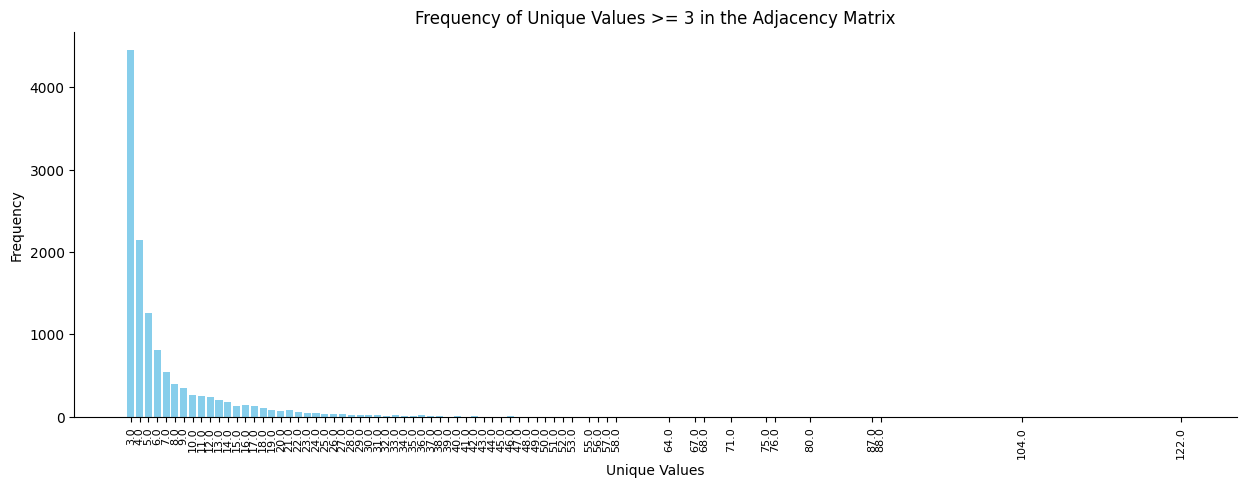

In [138]:
# Convert the adjacency matrix to a numpy array
adjacency_array = adjacency_matrix.to_numpy()

# Filter values below the syn_threshold 
filtered_values = adjacency_array[adjacency_array >= syn_threshold]

# Extract unique values and their frequencies
unique_values, counts = np.unique(filtered_values, return_counts=True)

# Create a dictionary of unique values and their frequencies
value_counts = dict(zip(unique_values, counts))

from matplotlib.ticker import FixedLocator

# Plot the frequencies
plt.figure(figsize=(15, 5))
ax = plt.subplot(111)
ax.bar(value_counts.keys(), value_counts.values(), color='skyblue')
ax.set_xlabel('Unique Values')
ax.set_ylabel('Frequency')
ax.set_title(f'Frequency of Unique Values >= {syn_threshold} in the Adjacency Matrix')

# Set fixed ticks and labels
ticks = list(value_counts.keys())
ax.set_xticks(ticks)
ax.xaxis.set_major_locator(FixedLocator(ticks))
ax.set_xticklabels(ticks, rotation=90, size=8)

ax.spines[['right', 'top']].set_visible(False)
plt.show()

I am checking next the relative frequency of each value.

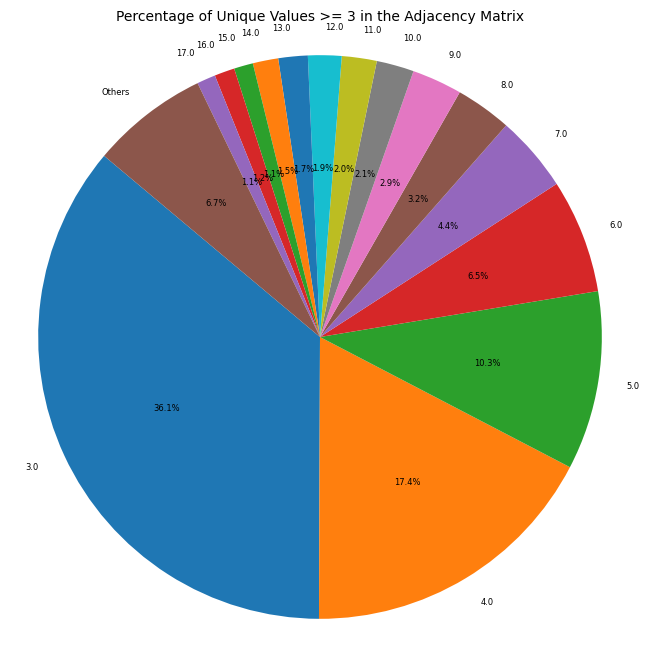

In [139]:
# Calculate percentages
percentages = (counts / np.sum(counts)) * 100

# Combine slices less than 1% into 'Others'
threshold_percentage = 1
mask = percentages >= threshold_percentage
combined_values = unique_values[mask]
combined_counts = counts[mask]
others_count = np.sum(counts[~mask])

if others_count > 0:
    combined_values = np.append(combined_values, 'Others')
    combined_counts = np.append(combined_counts, others_count)

# Calculate percentages for combined values
combined_percentages = (combined_counts / np.sum(combined_counts)) * 100

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(combined_percentages, labels=combined_values, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 6})
plt.title(f'Percentage of Unique Values >= {syn_threshold} in the Adjacency Matrix', fontsize=10)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [140]:
# Some checks before creating a network graph

# Synaptic filter: replace values lower than 5 with 0
#thresholded_adjacency_matrix = adjacency_matrix.applymap(lambda x: 0 if x < syn_threshold else x)
thresholded_adjacency_matrix = adjacency_matrix_mapped.applymap(lambda x: 0 if x < syn_threshold else x)

# Print index (rows) and columns of the DataFrame
print("Index (rows):", thresholded_adjacency_matrix.index)
print("Columns:", thresholded_adjacency_matrix.columns)

# Compare and check for discrepancies
missing_in_columns = list(set(thresholded_adjacency_matrix.index).difference(set(thresholded_adjacency_matrix.columns)))
if missing_in_columns:
    print(f"Nodes missing in columns: {missing_in_columns}")

missing_in_index = list(set(thresholded_adjacency_matrix.columns).difference(set(thresholded_adjacency_matrix.index)))
if missing_in_index:
    print(f"Nodes missing in index: {missing_in_index}")

# Check if index (rows) and columns are in the same order
if list(thresholded_adjacency_matrix.index) == list(thresholded_adjacency_matrix.columns):
    print("Nodes are in the same order in both rows and columns.")
else:
    print("Nodes are not in the same order in rows and columns.")

Index (rows): Index(['Dm19', 'Dm8', 'Dm13', 'Dm9', 'Dm20', 'Dm8_1', 'Dm8_2', 'Dm6', 'Dm1',
       'Dm2',
       ...
       'Dm9_124', 'Dm9_125', 'Dm9_126', 'Dm8_363', 'Dm3_1258', 'Dm3_1259',
       'Dm8_364', 'Dm8_365', 'Dm2_579', 'Dm3_1260'],
      dtype='object', name='source', length=3209)
Columns: Index(['Dm19', 'Dm8', 'Dm13', 'Dm9', 'Dm20', 'Dm8_1', 'Dm8_2', 'Dm6', 'Dm1',
       'Dm2',
       ...
       'Dm9_124', 'Dm9_125', 'Dm9_126', 'Dm8_363', 'Dm3_1258', 'Dm3_1259',
       'Dm8_364', 'Dm8_365', 'Dm2_579', 'Dm3_1260'],
      dtype='object', name='target', length=3209)
Nodes are in the same order in both rows and columns.


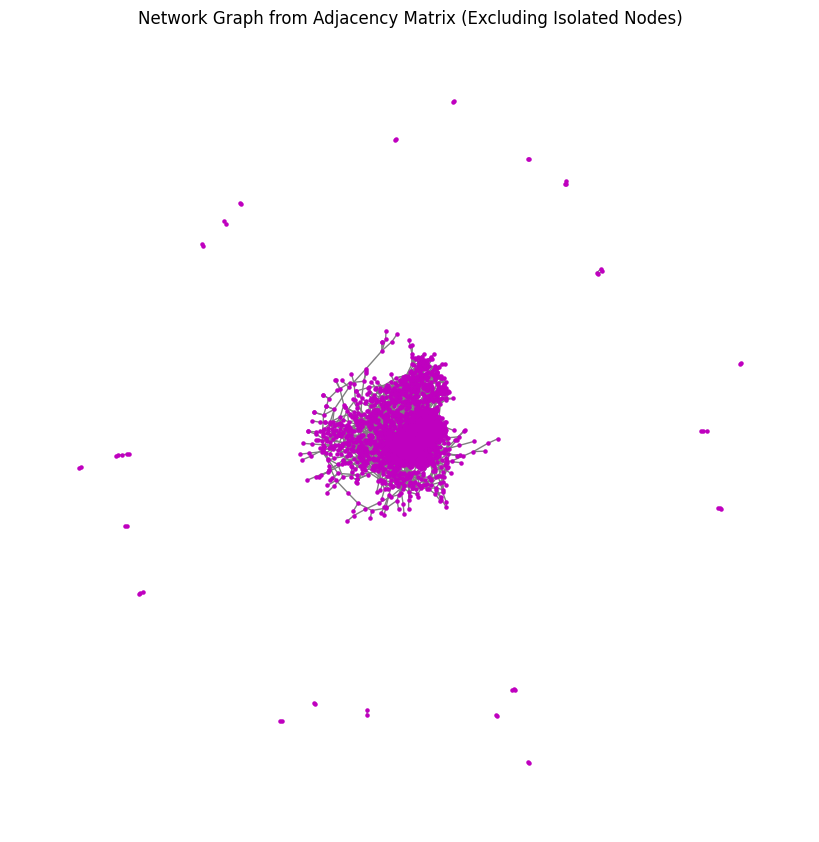

In the connectivity matrix: 
 Number of rows: 3209, Number of columns: 3209


In [141]:
# Quick visualizations with Network Graph

# Synaptic filter: replace values lower than 5 with 0
#thresholded_adjacency_matrix = adjacency_matrix.applymap(lambda x: 0 if x < syn_threshold else x)
thresholded_adjacency_matrix = adjacency_matrix_mapped.applymap(lambda x: 0 if x < syn_threshold else x)


# Create a graph from the adjacency matrix
#G = nx.from_numpy_array(thresholded_adjacency_matrix.values)
G = nx.from_pandas_adjacency(thresholded_adjacency_matrix)

# Identify isolated nodes (nodes with zero degree)
isolated_nodes = [node for node, degree in dict(G.degree()).items() if degree == 0]


# Create a subgraph excluding isolated nodes
H = G.subgraph([node for node in G.nodes() if node not in isolated_nodes])


# Draw the network
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(H)
nx.draw(H, pos, with_labels=False, node_size=5, node_color='m', edge_color='gray', font_size=12, font_color='black')
plt.title('Network Graph from Adjacency Matrix (Excluding Isolated Nodes)')
plt.show()

# Printinf info:
# Check the size of the matrix (number of rows and columns)
num_rows, num_cols = thresholded_adjacency_matrix.shape
print(f"In the connectivity matrix: \n Number of rows: {num_rows}, Number of columns: {num_cols}")



### 5. Subnetwork analysis

To identify possible subnetworks (also known as communities or clusters) within your graph H, where nodes are more interconnected to each other compared to the rest of the graph, you can perform community detection or clustering analysis. Here are a few approaches commonly used in network analysis:

#### 5.1. Modularity Maximization:
Modularity is a measure that quantifies the strength of division of a network into modules (or communities). Modularity maximization algorithms aim to find a partition of nodes that maximizes this measure.

In [142]:
# Getting the different communities

from networkx.algorithms import community

# Detect communities using greedy modularity maximization
communities = list(community.greedy_modularity_communities(H))
print(f'Total number of identified communities: {len(communities)}')

Total number of identified communities: 31


In [143]:
# Mapping communities IDs to symbols

from collections import defaultdict

# Create a dictionary to map unique labels to symbols
label_to_symbol = {row['unique_label']: row['symbol'] for index, row in filtered_df.iterrows()}

# Create a list of communities where each community contains symbols instead of unique labels
symbol_communities = []
for community in communities:
    symbol_community = [label_to_symbol[label.split('_')[0]] for label in community]
    symbol_communities.append(symbol_community)

print(f'Total number of symbol communities: {len(communities)}')

Total number of symbol communities: 31


In [144]:
## Counting the occurrences of each symbol across communities

from collections import Counter

symbol_count = Counter()
for community in symbol_communities:
    symbol_count.update(community)

# Convert symbol_count to a list of tuples for easier sorting
symbol_count = list(symbol_count.items())

# Sort symbols by their counts (descending)
symbol_count.sort(key=lambda x: x[1], reverse=True)



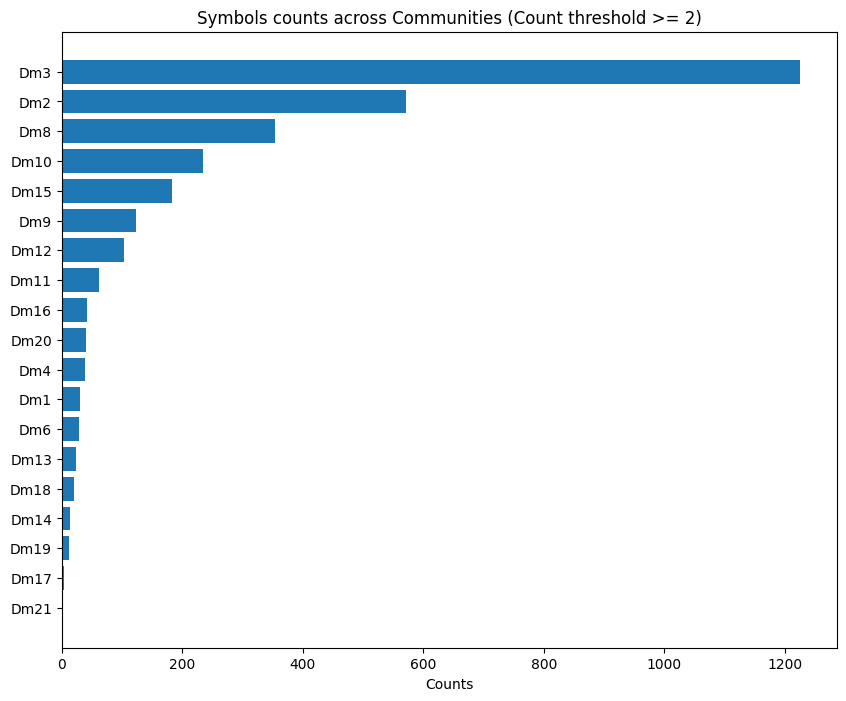

In [145]:
## Quick visualization

# Set the count threshold
count_threshold = 2

# Filter symbols based on count_threshold
filtered_symbol_count = [(symbol, count) for symbol, count in symbol_count if count >= count_threshold]

# Extract symbols and counts for plotting
symbols, counts = zip(*filtered_symbol_count)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(range(len(symbols)), counts, align='center')
plt.yticks(range(len(symbols)), symbols)
plt.xlabel('Counts')
plt.title('Symbols counts across Communities (Count threshold >= {})'.format(count_threshold))
plt.gca().invert_yaxis()  # Invert y-axis to have the most common symbol at the top
plt.show()


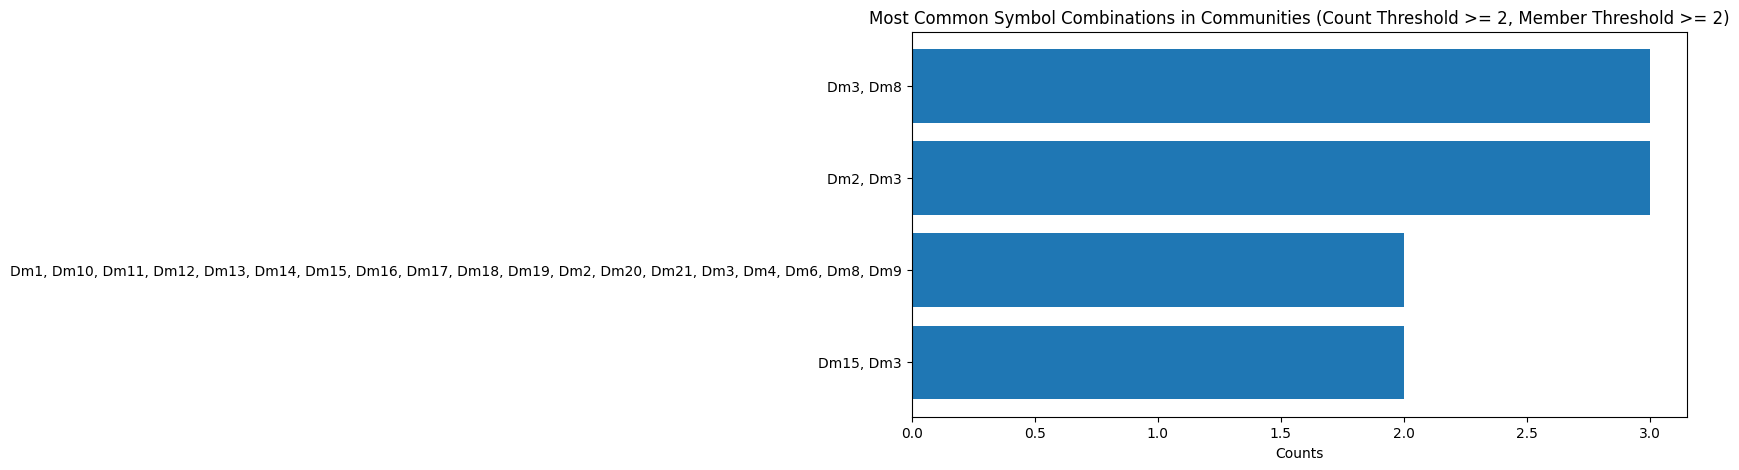

Total number of combinations: 4


In [146]:
## Getting unique combinations of symbols across communities

# Define the count_threshold and member_threshold
count_threshold = 2
member_threshold = 2

# Convert each community to a set of symbols
symbol_sets = [set(community) for community in symbol_communities]

# Initialize a defaultdict to count combinations
combination_count = defaultdict(int)

# Iterate through symbol sets and count combinations
for symbols in symbol_sets:
    if len(symbols) >= member_threshold:
        # Convert set to tuple to make it hashable and use as a key in defaultdict
        combination_count[tuple(sorted(symbols))] += 1

# Filter combinations based on count_threshold and member_threshold
combination_count_filtered = [(comb, count) for comb, count in combination_count.items() if count >= count_threshold]

# Sort combinations by their counts (descending)
combination_count_filtered.sort(key=lambda x: x[1], reverse=True)

# Extract filtered combinations and counts
filtered_combinations = [comb for comb, count in combination_count_filtered]
filtered_counts = [count for comb, count in combination_count_filtered]

# Plotting
plt.figure(figsize=(10, 5))
plt.barh(range(len(filtered_combinations)), filtered_counts, align='center')
plt.yticks(range(len(filtered_combinations)), [", ".join(comb) for comb in filtered_combinations])
plt.xlabel('Counts')
plt.title(f'Most Common Symbol Combinations in Communities (Count Threshold >= {count_threshold}, Member Threshold >= {member_threshold})')
plt.gca().invert_yaxis()  # Invert y-axis to have the most common combination at the top
plt.show()

print(f'Total number of combinations: {len(filtered_combinations)}')

#### 5.2. Hierarchical Clustering:
Hierarchical clustering methods create a hierarchy of clusters. In the context of networks, these methods can group nodes into nested clusters based on their similarity in connectivity.



In [147]:
from scipy.cluster import hierarchy

# Convert the graph to a SciPy sparse matrix
adj_matrix_sparse = nx.to_scipy_sparse_array(H)

# Convert the sparse matrix to a dense format
adj_matrix_dense = adj_matrix_sparse.toarray()

# Compute hierarchical clustering
# Flatten the matrix to 1D array to get pairwise distances
condensed_distance_matrix = hierarchy.distance.pdist(adj_matrix_dense)
Z = hierarchy.linkage(condensed_distance_matrix, method='average')

# Extract clusters from the hierarchical clustering
clusters = hierarchy.fcluster(Z, t=1.0, criterion='distance')

# Create a dictionary of nodes in each cluster
cluster_dict = {}
for node, cluster_id in zip(H.nodes(), clusters):
    if cluster_id not in cluster_dict:
        cluster_dict[cluster_id] = []
    cluster_dict[cluster_id].append(node)

print(f'Total number of identified cluster: {len(cluster_dict)}')

Total number of identified cluster: 3079


In [148]:
# Create a dictionary to map unique labels to symbols
label_to_symbol = {row['unique_label']: row['symbol'] for index, row in filtered_df.iterrows()}

# Map cluster IDs to symbols
cluster_symbol_map = {}
for cluster_id, nodes in cluster_dict.items():
    symbols = set()
    for node in nodes:
        label = node.split('_')[0]  # Extract the label from the node ID
        if label in label_to_symbol:
            symbols.add(label_to_symbol[label])
    cluster_symbol_map[cluster_id] = symbols

print(f'Total number of identified cluster: {len(cluster_symbol_map)}')

Total number of identified cluster: 3079


In [149]:
from collections import Counter

symbol_count_across_clusters = Counter()
for symbols in cluster_symbol_map.values():
    symbol_count_across_clusters.update(symbols)

# Convert symbol_count_across_clusters to a list of tuples for easier sorting
symbol_count_across_clusters = list(symbol_count_across_clusters.items())

# Sort symbols by their counts (descending)
symbol_count_across_clusters.sort(key=lambda x: x[1], reverse=True)

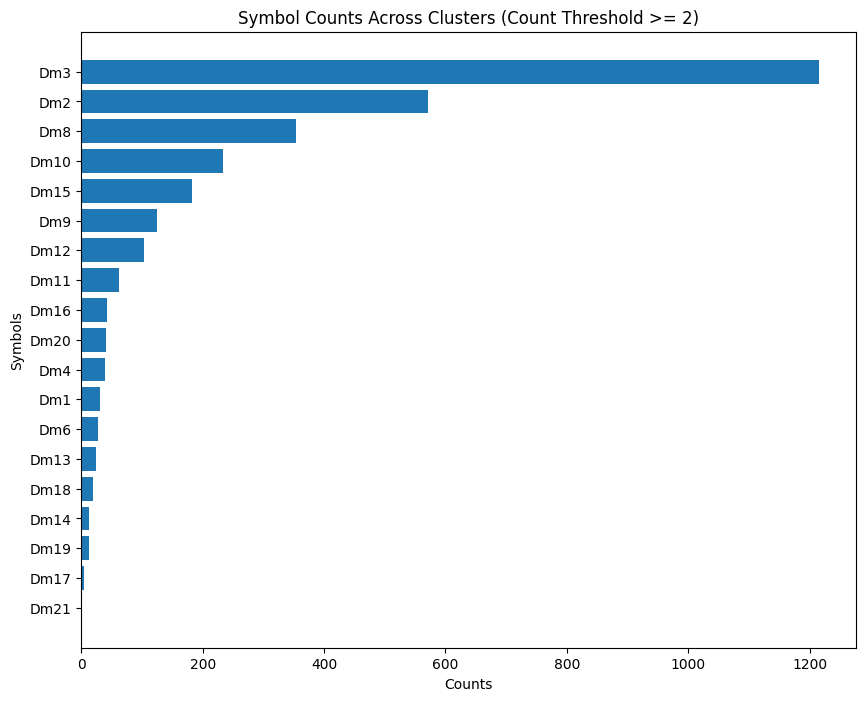

In [151]:
# Set the count threshold
count_threshold = 2

# Extract symbols and counts, filtering based on count_threshold
symbols_filtered = [sym for sym, count in symbol_count_across_clusters if count >= count_threshold]
counts_filtered = [count for sym, count in symbol_count_across_clusters if count >= count_threshold]

# Plotting symbol counts across clusters
plt.figure(figsize=(10, 8))
plt.barh(range(len(symbols_filtered)), counts_filtered, align='center')
plt.yticks(range(len(symbols_filtered)), symbols_filtered)
plt.xlabel('Counts')
plt.ylabel('Symbols')
plt.title(f'Symbol Counts Across Clusters (Count Threshold >= {count_threshold})')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count at the top
plt.show()

In [152]:
# Creating a dictionary to count occurrences of each set of members
cluster_type_count = defaultdict(int)

for cluster_id, members in cluster_symbol_map.items():
    # Convert members to a frozenset to ignore order and make it hashable
    member_set = frozenset(members)
    cluster_type_count[member_set] += 1


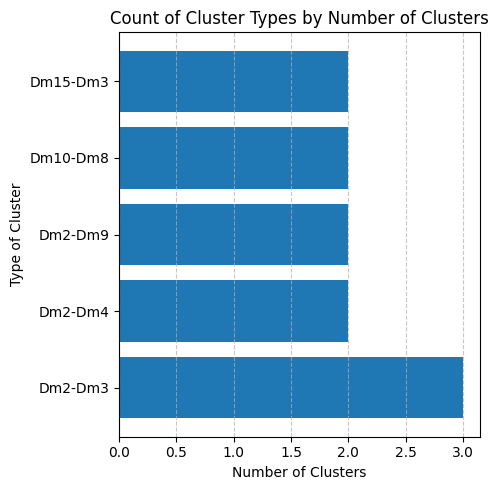

In [155]:
# Filter based on thresholds
count_threshold = 2
member_threshold = 2

filtered_cluster_type_count = {
    member_set: count for member_set, count in cluster_type_count.items()
    if count >= count_threshold and len(member_set) >= member_threshold
}

# Prepare data for plotting
x = list(filtered_cluster_type_count.values())
y = [sorted(member_set) for member_set in filtered_cluster_type_count.keys()]

# Plotting the data
plt.figure(figsize=(5, 5))
plt.barh(["-".join(members) for members in y], x)
plt.xlabel('Number of Clusters')
plt.ylabel('Type of Cluster')
plt.title('Count of Cluster Types by Number of Clusters')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()